## Analysing & Modeling Gentrification Trends in New York City

In [1]:
pip install contextily

In [2]:
pip install geopandas

In [3]:
pip install keplergl

In [4]:
pip install splot

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
pip install rioxarray

     |████████████████████████████████| 47 kB 4.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for rioxarray: filename=rioxarray-0.9.1-py3-none-any.whl size=54611 sha256=fb393db6d70d196a90e3369480d16bce423f550eaec8e8eee25059732c588485
  Stored in directory: /root/.cache/pip/wheels/07/da/9e/1cc57b2e7a29a206893db83e984a341e2e94378263e0798229
Successfully built rioxarray


In [7]:
pip install pysal

     |████████████████████████████████| 5.7 MB 10.0 MB/s 
     |████████████████████████████████| 147 kB 23.6 MB/s 
     |████████████████████████████████| 55 kB 3.0 MB/s 
     |████████████████████████████████| 41 kB 364 kB/s 
     |████████████████████████████████| 243 kB 14.6 MB/s 
     |████████████████████████████████| 83 kB 2.0 MB/s 
     |████████████████████████████████| 46 kB 3.5 MB/s 
     |████████████████████████████████| 2.1 MB 36.9 MB/s 
     |████████████████████████████████| 66.7 MB 15 kB/s 
     |████████████████████████████████| 78 kB 2.8 MB/s 
     |████████████████████████████████| 183 kB 51.0 MB/s 
     |████████████████████████████████| 1.0 MB 36.2 MB/s 
     |████████████████████████████████| 14.2 MB 37.9 MB/s 
     |████████████████████████████████| 596 kB 39.5 MB/s 
     |████████████████████████████████| 132 kB 47.0 MB/s 
     |████████████████████████████████| 8.7 MB 42.4 MB/s 
     |████████████████████████████████| 79 kB 5.0 MB/s 
  Using cached urllib3-1.2

In [8]:
pip install pyyaml==5.4.1

     |████████████████████████████████| 636 kB 15.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0


In [9]:
pip install pandana

     |████████████████████████████████| 1.7 MB 21.9 MB/s 
     |████████████████████████████████| 4.3 MB 42.5 MB/s 
  Attempting uninstall: tables
    Found existing installation: tables 3.7.0
    Uninstalling tables-3.7.0:
      Successfully uninstalled tables-3.7.0


In [10]:
import numpy as np
import pandas as pd
import geopandas as gpd
from keplergl import KeplerGl
from matplotlib import pyplot as plt
import seaborn                   #for plotting graphs
from splot import esda as esdaplot
from scipy.spatial.distance import cdist, pdist
import plotly.graph_objects as go #for plotting graphs
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture
import rioxarray                 # Surface data manipulation
import xarray                    # Surface data manipulation
from pysal.explore import esda   # Exploratory Spatial analytics
from pysal.lib import weights    # Spatial weights
import contextily 

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
/usr/local/lib/python3.7/dist-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg

Data is obtained from US Census data for years 2012 and 2019 to do spatial analysis to measure NYC gentrification. 

Our main goal is to identify, characterise and locate neighborhoods in New York City which have undergone recent gentrification and to explore the neighborhoods which are likely to be next in line.

In [11]:
#Read data from CSV 
data_2012 = pd.read_csv('/content/drive/MyDrive/Machine Learning- Gentrification and more!/MLC_Project_Final/data_2014.csv', usecols = ['GEOID', 'm_income','m_rent','m_own','perc_white','perc_poverty','perc_o25_ed','owner_occ','rent_occ','rent_vac','temp_vac'])                       
data_2019 = pd.read_csv('/content/drive/MyDrive/Machine Learning- Gentrification and more!/MLC_Project_Final/data_2017.csv', usecols = ['GEOID', 'm_income','m_rent','m_own','perc_white','perc_poverty','perc_o25_ed','owner_occ','rent_occ','rent_vac','temp_vac'])
                        

In [12]:
#renaming the existing names
dict_rename = {'m_income':'median_HH_income','m_rent':'median_rent','m_own':'median_val_own_prop'} 
# call rename () method
data_2012 = data_2012.rename(columns=dict_rename).set_index("GEOID")
data_2019 = data_2019.rename(columns=dict_rename).set_index("GEOID")
#same geo-ids across years are considered for analysis
geo_ids_considered = list(set(data_2019.index.tolist()).intersection(set(data_2012.index.tolist())))
data_2012 = data_2012[data_2012.index.isin(geo_ids_considered)]
data_2019 = data_2019[data_2019.index.isin(geo_ids_considered)]

In [13]:
#Curation of data 
#imputed the Nan Values with mean of respective data
data_2012['median_HH_income'] = data_2012['median_HH_income'].fillna(data_2012['median_HH_income'].mean())
data_2012['median_rent'] = data_2012['median_rent'].fillna(data_2012['median_rent'].mean())
data_2012['median_val_own_prop'] = data_2012['median_val_own_prop'].fillna(data_2012['median_val_own_prop'].mean())
data_2019['median_HH_income'] = data_2019['median_HH_income'].fillna(data_2019['median_HH_income'].mean())
data_2019['median_rent'] = data_2019['median_rent'].fillna(data_2019['median_rent'].mean())
data_2019['median_val_own_prop'] = data_2019['median_val_own_prop'].fillna(data_2019['median_val_own_prop'].mean())

In [14]:
merged_data = pd.concat([data_2012,data_2019])

### Applying PCA on 2012 and 2019 data

In [15]:
#scaling the data to standard scaler
scaler_data = preprocessing.StandardScaler().fit(merged_data)
dataS=scaler_data.transform(merged_data) 

In [16]:
#perform PC decomposition over data
pca = PCA(1)
dataP=pca.fit_transform(dataS)
eigenvalues = pca.explained_variance_ratio_

In [17]:
print("The amount of explained variance is: {0:6.5f}".format(pca.explained_variance_ratio_[0]))

The amount of explained variance is: 0.45722


In [18]:
merged_data['gentri_score'] = dataP

In [19]:
data_2012_scored = merged_data.iloc[:len(data_2012)].reset_index()
data_2019_scored = merged_data.iloc[len(data_2019):].reset_index()

In [20]:
data_2012_scored.rename(columns = {'gentri_score':'gentri_score_2012'}, inplace = True)
data_2019_scored.rename(columns = {'gentri_score':'gentri_score_2019'}, inplace = True)

In [21]:
data_2019_scored.head()

,GEOID,median_HH_income,median_rent,median_val_own_prop,perc_white,perc_poverty,perc_o25_ed,owner_occ,rent_occ,rent_vac,temp_vac,gentri_score_2019
0,14000US36005000200,62773.0,1250.0,399400.0,0.007711,0.227101,0.402560,0.439590,0.462116,0.000000,0.000000,-0.752544
1,14000US36005000400,82697.0,1278.0,376500.0,0.034489,0.123514,0.662440,0.699717,0.213881,0.033994,0.000000,1.012892
2,14000US36005001600,33118.0,989.0,389600.0,0.036958,0.283894,0.368242,0.121760,0.837653,0.030807,0.000000,-2.606616
3,14000US36005001900,40117.0,1181.0,375000.0,0.077387,0.291022,0.528035,0.098328,0.854474,0.009833,0.009833,-1.940070
4,14000US36005002000,18370.0,607.0,391800.0,0.013739,0.528627,0.280098,0.173071,0.787254,0.020619,0.000000,-3.983057


In [22]:
merged_scored = pd.merge(data_2012_scored[['GEOID','gentri_score_2012']], data_2019_scored[['GEOID','gentri_score_2019']], on=["GEOID"])

In [23]:
merged_scored['gentrification_ind'] = merged_scored.apply(lambda x: x['gentri_score_2019']-x['gentri_score_2012'], axis=1)


In [24]:
merged_scored.head()

,GEOID,gentri_score_2012,gentri_score_2019,gentrification_ind
0,14000US36005000200,-0.237642,-0.752544,-0.514903
1,14000US36005000400,1.254476,1.012892,-0.241584
2,14000US36005001600,-2.220313,-2.606616,-0.386303
3,14000US36005001900,-2.499877,-1.940070,0.559807
4,14000US36005002000,-3.297142,-3.983057,-0.685915


In [25]:
geo_df = gpd.read_file('/content/drive/MyDrive/Machine Learning- Gentrification and more!/MLC_Project_Final/geo_key.shp')
geo_df = geo_df.rename(columns={'key':'GEOID'})
merged_scored = pd.merge(merged_scored, geo_df, on=['GEOID'])

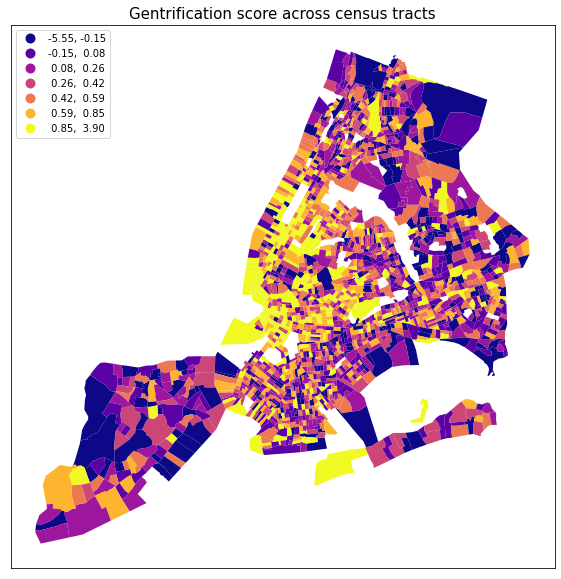

In [26]:
merged_scored= gpd.GeoDataFrame(merged_scored)
merged_scored.plot(figsize = (10,10), column='gentrification_ind', scheme='Quantiles', k=7,cmap ="plasma",legend=True,legend_kwds={'loc': 'upper left'})
plt.title("Gentrification score across census tracts", fontsize=15)
plt.grid(False)
plt.yticks([])
plt.xticks([])
plt.show()

### Stage 2

Applying local spatial statistics

In [27]:
# Generate W from the GeoDataFrame
w = weights.distance.KNN.from_dataframe(merged_scored, k=8)
# Row-standardization
w.transform = 'R'

In [28]:
merged_scored['w_gentrification_ind'] = weights.spatial_lag.lag_spatial(w, merged_scored['gentrification_ind'])

In [29]:
merged_scored['gentrification_std'] = ( merged_scored['gentrification_ind'] - merged_scored['gentrification_ind'].mean() )
merged_scored['w_gentrification_std'] = (merged_scored['w_gentrification_ind'] - merged_scored['w_gentrification_ind'].mean() )

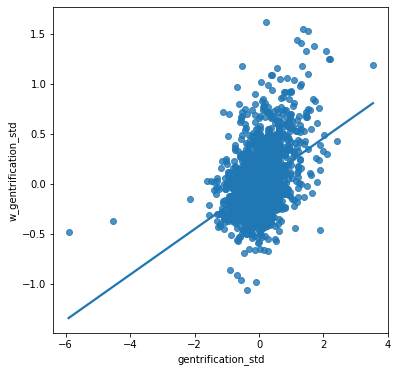

In [30]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
seaborn.regplot(
    x='gentrification_std', y='w_gentrification_std', data=merged_scored, ci=None
);

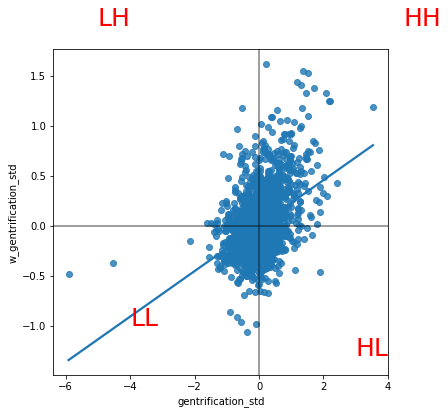

In [31]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
seaborn.regplot('gentrification_std', y='w_gentrification_std', data=merged_scored, ci=None
)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Add text labels for each quadrant
plt.text(4.5, 2, "HH", fontsize=25, c='r')
plt.text(3, -1.3, "HL", fontsize=25, c='r')
plt.text(-5, 2, "LH", fontsize=25, c='r')
plt.text(-4, -1.0, "LL", fontsize=25, c='r')
# Display
plt.show()

In [32]:
lisa = esda.moran.Moran_Local(merged_scored['gentrification_ind'], w)

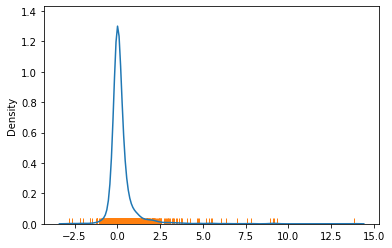

In [33]:
# Draw KDE line
ax = seaborn.kdeplot(lisa.Is)
# Add one small bar (rug) for each observation
# along horizontal axis
seaborn.rugplot(lisa.Is, ax=ax);

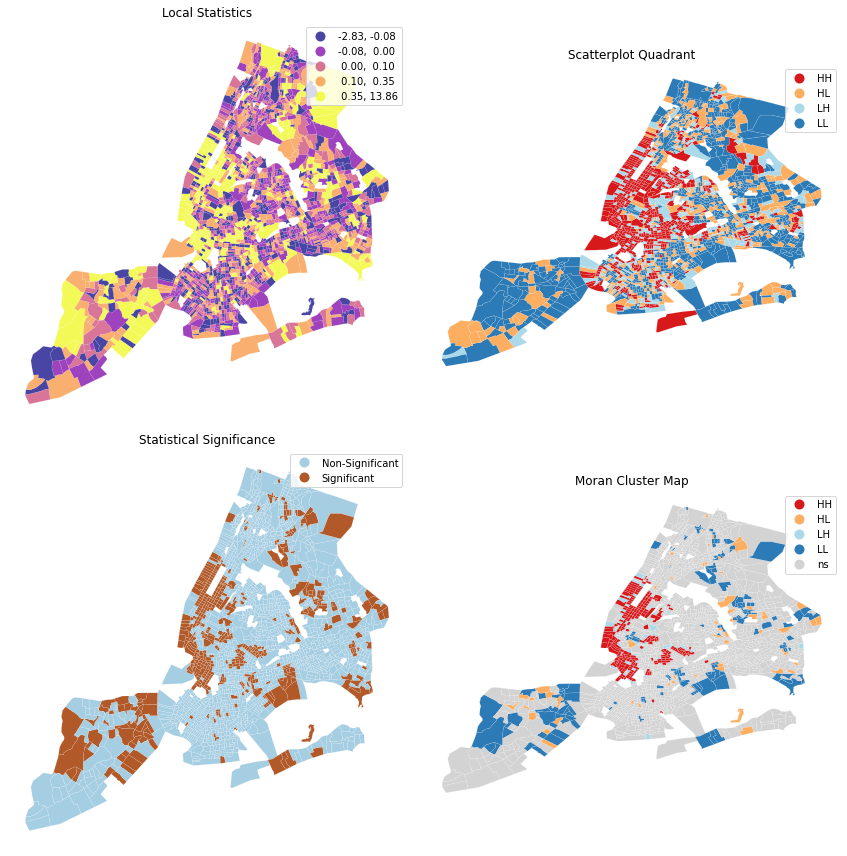

In [34]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

                    # Subplot 1 #
            # Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]
# Assign new column with local statistics on-the-fly
merged_scored.assign(
    Is=lisa.Is
# Plot choropleth of local statistics
).plot(
    column='Is', 
    cmap='plasma', 
    scheme='quantiles',
    k=5, 
    edgecolor='white', 
    linewidth=0.1, 
    alpha=0.75,
    legend=True,
    ax=ax
)

                    # Subplot 2 #
                # Quadrant categories
# Grab second axis of local statistics
ax = axs[1]
# Plot Quandrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(lisa, merged_scored, p=1, ax=ax);

                    # Subplot 3 #
                # Significance map
# Grab third axis of local statistics
ax = axs[2]
# 
# Find out significant observations
labels = pd.Series(
    1 * (lisa.p_sim < 0.05), # Assign 1 if significant, 0 otherwise
    index=merged_scored.index           # Use the index in the original data
# Recode 1 to "Significant and 0 to "Non-significant"
).map({1: 'Significant', 0: 'Non-Significant'})
# Assign labels to `db` on the fly
merged_scored.assign(
    cl=labels
# Plot choropleth of (non-)significant areas
).plot(
    column='cl', 
    categorical=True,
    k=2,
    cmap='Paired',
    linewidth=0.1,
    edgecolor='white',
    legend=True,
    ax=ax
)

                       
                    # Subplot 4 #
                    # Cluster map
# Grab second axis of local statistics
ax = axs[3]
# Plot Quandrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa, merged_scored, p=0.05, ax=ax);

                    # Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            'Local Statistics', 
            'Scatterplot Quadrant', 
            'Statistical Significance', 
            'Moran Cluster Map'
        ][i], y=0
    )
# Tight layout to minimise in-betwee white space
f.tight_layout()

# Display the figure
plt.show()

In [35]:
lisa.q[:10]

array([3, 3, 3, 1, 3, 3, 4, 3, 2, 4])

In [36]:
counts = pd.value_counts(lisa.q)
counts

3    749
1    557
4    465
2    346
dtype: int64

In [37]:
(lisa.p_sim < 0.05).sum() * 100 / len(lisa.p_sim)

23.05148795465281

In [38]:
# Assign pseudo P-values to `merged_scored`
merged_scored['p-sim'] = lisa.p_sim
# `1` if significant (at 5% confidence level), `0` otherwise
sig = 1 * (lisa.p_sim < 0.05)
# Assign significance flag to `db`
merged_scored['sig'] = sig
# Print top of the table to inspect
merged_scored[['sig','p-sim']].head()

,sig,p-sim
0,1,0.005
1,0,0.069
2,1,0.038
3,0,0.447
4,1,0.018


In [39]:
# Pick as part of a quadrant only significant polygons, 
# assign `0` otherwise (Non-significant polygons)
spots = lisa.q * sig
# Mapping from value to name (as a dict)
spots_labels = {
    0: 'Non-Significant', 1:'HH', 2: 'LH', 3:'LL', 4: 'HL'
}
# Create column in `db` with labels for each polygon
merged_scored['labels'] = pd.Series(
    # First initialise a Series using values and `db` index
    spots, index=merged_scored.index
# Then map each value to corresponding label based 
# on the `spots_labels` mapping
).map(spots_labels)
# Print top for inspection
merged_scored['labels'].head()

0                 LL
1    Non-Significant
2                 LL
3    Non-Significant
4                 LL
Name: labels, dtype: object

In [40]:
merged_scored['labels'].value_counts()

Non-Significant    1629
HH                  217
LL                  160
HL                   62
LH                   49
Name: labels, dtype: int64

In [41]:
dummy=pd.get_dummies(merged_scored['labels'])
merged_scored['HH']=dummy['HH']
merged_scored['HL']=dummy['HL']
merged_scored['LH']=dummy['LH']
merged_scored['LL']=dummy['LL']

In [42]:
merged_scored=merged_scored[['GEOID','gentri_score_2012','gentri_score_2019','gentrification_ind','HH','HL','LH','LL','geometry']]

In [43]:
merged_scored

,GEOID,gentri_score_2012,gentri_score_2019,gentrification_ind,HH,HL,LH,LL,geometry
0,14000US36005000200,-0.237642,-0.752544,-0.514903,0,0,0,1,"POLYGON ((-73.86522 40.81453, -73.86425 40.814..."
1,14000US36005000400,1.254476,1.012892,-0.241584,0,0,0,0,"POLYGON ((-73.85960 40.81528, -73.85870 40.815..."
2,14000US36005001600,-2.220313,-2.606616,-0.386303,0,0,0,1,"POLYGON ((-73.86246 40.81925, -73.86153 40.819..."
3,14000US36005001900,-2.499877,-1.940070,0.559807,0,0,0,0,"POLYGON ((-73.93180 40.80788, -73.93094 40.808..."
4,14000US36005002000,-3.297142,-3.983057,-0.685915,0,0,0,1,"POLYGON ((-73.87050 40.82036, -73.86888 40.820..."
...,...,...,...,...,...,...,...,...,...
2112,14000US36085030301,0.519817,1.071953,0.552136,0,1,0,0,"POLYGON ((-74.16848 40.62156, -74.16814 40.622..."
2113,14000US36085030302,1.032318,1.382949,0.350631,0,0,0,0,"POLYGON ((-74.16814 40.62208, -74.16793 40.622..."
2114,14000US36085031901,-3.235209,-3.232801,0.002408,0,0,0,0,"POLYGON ((-74.16647 40.62852, -74.16645 40.629..."
2115,14000US36085031902,-2.090669,-1.924877,0.165792,0,0,0,0,"POLYGON ((-74.17129 40.64052, -74.17118 40.641..."


### Stage 3

k-means algorithm was used to isolate clusters of neighborhoods within the ascending areas, with similar ascent characteristics

In [44]:
ascending_df= merged_scored

In [45]:
ascending_2012 = data_2012[data_2012.index.isin(ascending_df.GEOID)].reset_index()
ascending_2019 = data_2019[data_2019.index.isin(ascending_df.GEOID)].reset_index()

In [46]:
change_asc_df = pd.merge(ascending_2012, ascending_2019, on=['GEOID'])

In [47]:
for col in ascending_2012:
    if col == 'GEOID':
        continue
    if col in ['median_HH_income', 'median_rent', 'median_val_own_prop']:
        change_asc_df['change_'+str(col)] = change_asc_df.apply(lambda x: (x[col+'_y'] - x[col+'_x'])/x[col+'_x'] if x[col+'_x'] > 0 else 0, axis=1)
    else:
        change_asc_df['change_'+str(col)] = change_asc_df[col+'_y'] - change_asc_df[col+'_x']

In [48]:
change_asc_df.loc[change_asc_df.change_median_val_own_prop>1, 'change_median_val_own_prop'] = 1

In [49]:
#features for gentrified areas to understand the impact
change_asc_df = change_asc_df[['GEOID','change_median_HH_income',
       'change_median_rent', 'change_median_val_own_prop', 'change_perc_white',
       'change_perc_poverty', 'change_perc_o25_ed', 'change_owner_occ',
       'change_rent_occ', 'change_rent_vac', 'change_temp_vac']]
spat=merged_scored[['GEOID','HH','HL','LH','LL']]
change_asc_df=change_asc_df.merge(spat,on='GEOID')

In [50]:
def elbow(data,K):
#data is your input as numpy form
#K is a list of number of clusters you would like to show.
    # Run the KMeans model and save all the results for each number of clusters
    KM = [KMeans(n_clusters=k).fit(data) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between the data with each center. 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    
    # But we only need the distance to the nearest centroid since we only calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    
    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()
    
    
    # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained')
    plt.title('Elbow for KMeans clustering')
    plt.show()

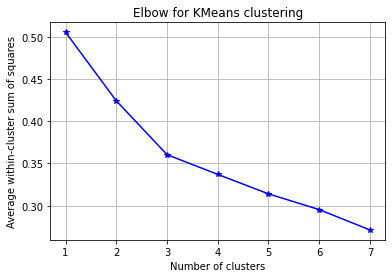

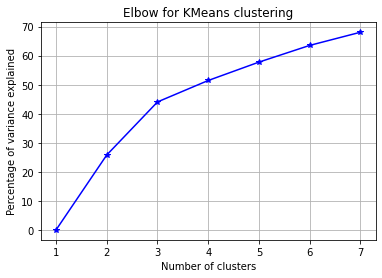

In [51]:
elbow(change_asc_df.set_index('GEOID'), range(1,8))

In [52]:
rr=KMeans(n_clusters=3, n_init=10, random_state=0).fit(change_asc_df.set_index('GEOID'))
# rr = GaussianMixture(n_components = 3, random_state = 0).fit(change_asc_df.set_index('GEOID'))
rr.labels_ = rr.predict(change_asc_df.set_index('GEOID')) #get labels

In [53]:
change_asc_df['cluster_id'] = rr.labels_
change_asc_df['cluster_id'] = change_asc_df['cluster_id'].astype(str)

In [54]:
change_asc_df = pd.merge(change_asc_df, geo_df, on=['GEOID'])

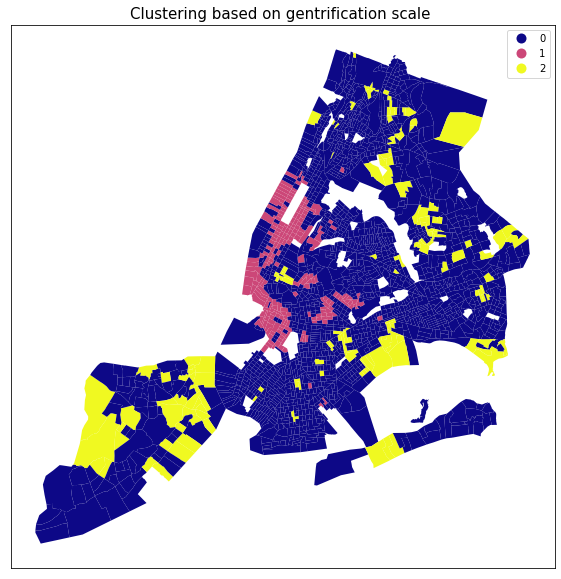

In [55]:
# Clusters of Ascending Neighborhoods 
change_asc_df= gpd.GeoDataFrame(change_asc_df)
change_asc_df.plot(figsize = (10,10), column='cluster_id',cmap ="plasma",legend=True)
plt.title("Clustering based on gentrification scale ", fontsize=15)
plt.grid(False)
plt.yticks([])
plt.xticks([])
plt.show()


In [56]:
change_asc_df['cluster_id'].value_counts()

0    1738
1     219
2     160
Name: cluster_id, dtype: int64

In [57]:
# Find general statistics for those areas with a positive score
mean_df=pd.DataFrame(data=change_asc_df.loc[:,'change_median_HH_income':'change_temp_vac'].mean()).rename(columns={0:'mean'})
std_df=pd.DataFrame(data=change_asc_df.loc[:,'change_median_HH_income':'change_temp_vac'].std()).rename(columns={0:'std'})
stat_df=mean_df.merge(std_df, left_index=True,right_index=True)


In [58]:
#Prepare statistics by cluster
clust=change_asc_df.loc[:,'change_median_HH_income':'cluster_id'].groupby(by='cluster_id').mean()
clust=clust.swapaxes('index','columns')
clust=clust.merge(stat_df, left_index=True,right_index=True)

#Normalize for graphing purposes
clust['norm0']=(clust['0']-clust['mean'])/clust['std']+1
clust['norm1']=(clust['1']-clust['mean'])/clust['std']+1
clust['norm2']=(clust['2']-clust['mean'])/clust['std']+1

In [59]:
fig = go.Figure()

fig.add_trace(go.Scatterpolar(r=clust.norm0,theta=clust.index,fill='toself',name='Cluster 0'))
fig.add_trace(go.Scatterpolar(r=clust.norm1,theta=clust.index,fill='toself',name='Cluster 1'))
fig.add_trace(go.Scatterpolar(r=clust.norm2,theta=clust.index,fill='toself',name='Cluster 2'))

fig.update_layout(polar=dict(radialaxis=dict(visible=True,range=[0, 2])),showlegend=True)

fig.show()

This radial chart shows us the relative values for each of the categories we clustered over. Cluster 0 clearly reflects changes we would expect to see with gentrification, whereas Cluster 1 reflects a relatively stationary neighborhood. Cluster 2 represents neighborhoods in relative decline.

This leads us to our new names for the clusters:
- Gentrifying
- Stationary
- Declining

In [64]:
clust[['0','1','2']].rename(columns={'1':'Gentrifying','0':'Stationary','2':'Declining'})

,Stationary,Gentrifying,Declining
change_median_HH_income,0.108600,0.217118,-0.011201
change_median_rent,0.094710,0.276400,0.048543
change_median_val_own_prop,0.130958,0.325674,0.084793
change_perc_white,-0.006437,0.005572,-0.014522
change_perc_poverty,-0.007029,-0.018610,0.023126
change_perc_o25_ed,0.016406,0.031676,-0.013347
change_owner_occ,0.006928,0.020403,-0.020606
change_rent_occ,-0.005401,-0.022515,0.024141
change_rent_vac,-0.004848,0.003013,-0.003659
change_temp_vac,0.000817,0.010100,0.000312


In [67]:
cluster_name=[]
for i in range(len(change_asc_df)):
  if change_asc_df.iloc[i]['cluster_id']=='0':
    cluster_name.append('stationary')
  elif change_asc_df.iloc[i]['cluster_id']=='1':
    cluster_name.append('gentrifying')
  elif change_asc_df.iloc[i]['cluster_id']=='2':
    cluster_name.append('declining')

change_asc_df['cluster_name']=cluster_name
change_asc_df['start_year']=2014
change_asc_df['end_year']=2017

In [68]:
change_asc_df[['GEOID','cluster_name','start_year','end_year','geometry']].to_csv('labels_14_17.csv')

### Stage 4



In [61]:
#concatenate 3 dfs over
#redo this with un12 --> with concatenated rows
# 

In [62]:
#getting just geoid and cluster id 
geo_dict = change_asc_df[['GEOID','cluster_id']]

In [63]:
#read in full df12 
df12 = pd.read_csv('/content/df12.csv')

FileNotFoundError: ignored

In [ ]:
##merge in original df12 dataframe with this merge on geoID 
df12_clusters = df12.merge(geo_dict,on='GEOID')

In [ ]:
cols_to_norm = ['B02001e1', 'B03002e1', 'B03002e3', 'B03002e4',
       'B03002e5', 'B03002e6', 'B03002e12', 'B17017e1', 'B17017e2', 'B19001e1',
       'B19001e2', 'B19001e3', 'B19001e4', 'B19001e5', 'B19001e6', 'B19001e7',
       'B19001e8', 'B19001e9', 'B19001e10', 'B19001e11', 'B19001e12',
       'B19001e13', 'B19001e14', 'B19001e15', 'B19001e16', 'B19001e17',
       'B19013e1', 'B25001e1', 'B25002e1', 'B25002e2', 'B25002e3', 'B25003e1',
       'B25003e2', 'B25003e3', 'B25004e1', 'B25004e2', 'B25004e3', 'B25004e4',
       'B25004e5', 'B25004e6', 'B25004e7', 'B25004e8', 'B25063e1', 'B25063e2',
       'B25063e3', 'B25063e4', 'B25063e5', 'B25063e6', 'B25063e7', 'B25063e8',
       'B25063e9', 'B25063e10', 'B25063e11', 'B25063e12', 'B25063e13',
       'B25063e14', 'B25063e15', 'B25063e16', 'B25063e17', 'B25063e18',
       'B25063e19', 'B25063e20', 'B25063e21', 'B25063e22', 'B25063e23',
       'B25063e24', 'B25064e1', 'B25075e1', 'B25075e2', 'B25075e3', 'B25075e4',
       'B25075e5', 'B25075e6', 'B25075e7', 'B25075e8', 'B25075e9', 'B25075e10',
       'B25075e11', 'B25075e12', 'B25075e13', 'B25075e14', 'B25075e15',
       'B25075e16', 'B25075e17', 'B25075e18', 'B25075e19', 'B25075e20',
       'B25075e21', 'B25075e22', 'B25075e23', 'B25075e24', 'B25075e25',
       'B25077e1']

In [ ]:
#normalize 
#here normalizing by columns - do we want to normalize by row/ tract?  
df12_normalized = df12_clusters

df12_normalized[cols_to_norm] = df12_clusters[cols_to_norm].apply(lambda x: (x - x.mean()) / x.std())

df12_normalized.head()

##### Random Forest

In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
#getting feature and target variables 
from sklearn.model_selection import train_test_split

y=df12_normalized.loc[:,"cluster_id"]

# Get the feature space.  We are using only features from before the stop, getting rid of features from during/after the stop like "arrested".
X=df12_normalized.loc[:,"B02001e1":"B25077e1"]

In [ ]:
#fill nas with means 

X = X.fillna(X.mean())

In [ ]:
#train test split 


X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.25,random_state=999)


In [ ]:
 #random forest with prediction accuracy
#packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score



In [ ]:
np.any(np.isnan(X))

In [ ]:
#initiating
#use tkey dm 
#not sure if this is working try for loop - always selecting lowest value 
rf = RandomForestClassifier()
#ranges of parameters for hypertuning
param_grid = {'n_estimators':[30,40,50,60],
              'max_depth':[4,6,8,10,12],
              'max_leaf_nodes':[4,6,8,10]}
#grid search 
gr=GridSearchCV(rf,param_grid=param_grid,scoring='roc_auc',n_jobs=-1)
#fitting
rs=gr.fit(X_train,y_train)
#print best parameters and OS score 
print(rs.best_params_)

#saving best params and accompanied AUC score 
#grid search only ever taking first parameters
#{'max_depth': 2, 'max_leaf_nodes': 6, 'n_estimators': 30} - AUC - 0.7057500869448082
#{'max_depth': 2, 'max_leaf_nodes': 2, 'n_estimators': 20} - AUC - 0.7013451776649747
#{'max_depth': 4, 'max_leaf_nodes': 4, 'n_estimators': 30} - AUC - 0.7168997260494723
#use these to plug back in to recreate random forest - more accuracy testing 

#do we want to do even split so enough of each class in train and test? 

In [ ]:
#attempting with for loop 
AUC_OS=[]
for i in range(2,100,5):
    rf = RandomForestClassifier(n_estimators=20, n_jobs=-1,max_leaf_nodes=25)    
    rf.fit(X_train,y_train)
    AUC_OS.append(roc_auc_score(np.array(y_test),rf.predict_proba(X_test),multi_class='ovo'))

In [ ]:
#plot
import matplotlib.pylab as plt
plt.figure(figsize=(7,5))
plt.plot(range(1,100,5),AUC_OS)
plt.xlabel("Number of Trees")
plt.ylabel("OS_AUC")
plt.title("AUC vs Number of Trees)")
plt.show()

In [ ]:
#with for loop 
#num estimators - 20 
#max_leaf_nodes - 25

In [ ]:
#now retrain random forest with selected parameters from loop
rf = RandomForestClassifier(n_estimators=20, n_jobs=-1,max_leaf_nodes=45)    
rf.fit(X_train,y_train)
roc_auc_score(np.array(y_test),rf.predict_proba(X_test),multi_class='ovo')
#0.768746072032874 - estimators - 20, max leaf nodes - 25 
#0.7720848440899202 - estimators - 20, max leaf nodes - 45

In [ ]:
#feature selection visualization 
plt.figure(figsize=(15,12))
features = X.columns
f_i = list(zip(features,rf.feature_importances_))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])
plt.rcParams.update({'font.size': 6})


plt.show()

#shows most important features

In [ ]:
#this takes time 
#select certain features and rerun and retrain model? 
from sklearn.feature_selection import RFECV

rfe = RFECV(rf,cv=5,scoring="neg_mean_squared_error")

rfe.fit(X_train,y_train)


selected_features = np.array(features)[rfe.get_support()]
#what are important features 

In [ ]:
selected_features
#most important features based on this
#'B03002e1', 'B03002e3', 'B03002e6', 'B03002e12', 'B17017e2','B19001e14', 'B19013e1', 'B25004e1', 'B25063e1', 'B25063e22','B25063e23', 'B25064e1', 'B25075e1', 'B25075e25', 'B25077e1'


In [ ]:
#!pip install graphviz
from sklearn.tree import export_graphviz

In [ ]:
#visualize single tree in forest 
from sklearn.tree import plot_tree


dot_data = export_graphviz(rf.estimators_[0], 
                           feature_names=X.columns, 
                           class_names=('Gentrifying','Stationary','Declining'),
                           filled=True, impurity=True, 
                           rounded=True)

graph = graphviz.Source(dot_data, format='png')
graph


In [ ]:
#save graph
graph.render('gentrification_tree')

In [ ]:
#use model to predict on 2019 --> identify areas that are being gentrified based on our model on 2019 stats

In [ ]:
#rf.predict_proba(X_test)

#reading in and normalizing df19
df19 = pd.read_csv('/df19.csv')

#seemingly lost some rows here - double check this 
df19_normalized = df19

df19_normalized[cols_to_norm] = df19[cols_to_norm].apply(lambda x: (x - x.mean()) / x.std())

df19_normalized.head()

In [ ]:
#y=df19_normalized.loc[:,"cluster_id"]

# Get the feature space.  We are using only features from before the stop, getting rid of features from during/after the stop like "arrested".
X19=df12_normalized.loc[:,"B02001e1":"B25077e1"]
X19 = X19.fillna(X19.mean())

In [ ]:
#predict class probabilities for 2019
preds = rf.predict_proba(X19)


In [ ]:
#merge back
df19_preds = pd.concat([df12_normalized, pd.DataFrame(preds.tolist())], axis=1)


In [ ]:
#highest with classification 0 - gentrifying
df19_preds.sort_values(0,ascending=False).head(10)['GEOID']

In [ ]:
#highest with classification 1 - stationary
df19_preds.sort_values(1,ascending=False).head(10)['GEOID']

In [ ]:
#highest with classification 2 - declining
df19_preds.sort_values(2,ascending=False).head(10)['GEOID']

##### Bayesian Network

In [ ]:
#aim for causality structure with bayes net 